In [102]:
#NOTE: The code below is configured to make running the code possible in Pace-ICE ondemand. You should either change the lines below to reflect your virtual env or comment them out.
import sys
'''sys.executable = 'miniconda3/envs/DRL/bin/python3.10'
sys.path += ['/home/hice1/jwessell6/DRL/VLMAgent/Gym_Snake', '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10', 
    '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10/site-packages', '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10/lib-dynload']'''
sys.path += ['/home/hice1/jwessell6/DRL/VLMAgent/Gym_Snake']
#normal imports
#import pandas as pd
import numpy as np
import torch 
from transformers import AutoProcessor, AutoModelForCausalLM, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig
import pickle
import argparse
import gym
import re

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import gym_snake

In [16]:
'''quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
model = LlavaOnevisionForConditionalGeneration.from_pretrained("llava-hf/llava-onevision-qwen2-72b-ov-hf", quantization_config = quantization_config, device_map="auto")
model.eval()
    #print(model.device)
processor = AutoProcessor.from_pretrained("llava-hf/llava-onevision-qwen2-7b-ov-hf")'''
import anthropic
import os
print(os.environ)
client = anthropic.Anthropic()

environ({'SHELL': '/bin/bash', 'LMOD_SITE_NAME': 'PACE', 'ZLIBROOT': '/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-12.3.0/zlib-1.2.13-3qhjpij2pji47kfanmlflvwk5ljcn5lh', 'CONDA_EXE': '/storage/ice1/1/6/jwessell6/miniconda3/bin/conda', '_CE_M': '', 'PKG_CONFIG_PATH': '/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-12.3.0/mvapich2-2.3.7-1-qv3gjagtbx5e3rlbdy6iy2sfczryftyt/lib/pkgconfig:/opt/pmix/4.2.6/lib/pkgconfig:/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-12.3.0/libxml2-2.10.3-ve5kggawwlt6jijzmrfy7idkx5hcwmuw/lib/pkgconfig:/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-12.3.0/xz-5.4.1-23t2osmoz6du7oygrv5zeiignuxhmmp4/lib/pkgconfig:/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-12.3.0/libpciaccess-0.17-pjfe4ct4gfm5k26s36hmewhbz4k232dl/lib/pkgconfig:/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-12.3.0/zlib-1.2.13-3qhjpij2pji47kfanmlflvwk5ljcn5lh/lib/pkgconfig:/usr/local/pace-apps/spack/packages

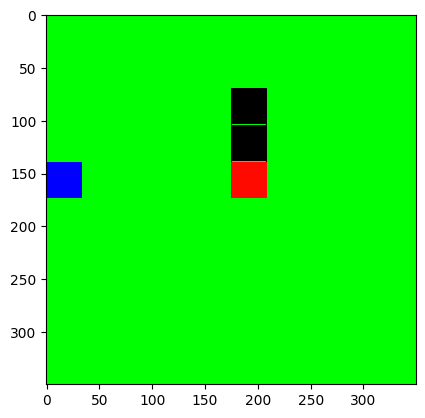

In [113]:
grid_size = [10,10]
env = gym.make('snake-v0', grid_size =grid_size, unit_size = 35)

state = env.reset()
image = state
plt.imshow(image)
im = Image.fromarray(image)
#im.save("FewShotEgs/snake350-2.png")

In [18]:
eg_img = Image.open("FewShotEgs/snake350.png")
#Gather information for the one-shot prompt
'''
plt.imshow(Image.fromarray(state))
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        if env.controller.grid.food_space((i,j)):
            food = [i, j]
            break
print(env.controller.snakes[0].head)
print(env.controller.snakes[0].direction)
print(food)'''
eg_info = ([10,10], [5,4], "down", [0,1])
eg_ans = """The snake is currently below and to the right and below the food. The snake shoulf move in the direction of the food, but it cannot move up. 
If the snake moved left, it would not go out of bounds or hit its tail, as in the image it is only about the snake. So, you should take the action 'left'."""

eg_img2 = Image.open("FewShotEgs/snake350-2.png")
eg_info2 = ([10,10], [2, 3], "left", [6, 9])
eg_ans2= """The snake is currently above and to the left of the food. The snake should move in the direction of the food. It cannot move to the right
as it is currently moving to the left. If the snake moves down, it will not hit its tail as shown in the image. So, you should take the action 'down'."""

In [114]:
import utils
import base64
import codecs
import pickle
import os
%load_ext autoreload
%autoreload 2


#image = statesave 
idx = 0
done = False 
while not done:
    if idx > 100:
        break
    im = Image.fromarray(state)
    im.save(f"agent_outputs/snake-claude1/{idx}.png")
    im.save("temp.png")
    with open("temp.png", "rb") as image_file:
        enc = base64.b64encode(image_file.read()).decode('utf-8')

    #enc = codecs.encode(pickle.dumps(image, protocol=pickle.HIGHEST_PROTOCOL), "base64").decode('utf-8')
    #images = [base64.standard_b64encode(eg_img).decode("utf-8"), base64.standard_b64encode(eg_img2).decode("utf-8"), base64.standard_b64encode(image).decode("utf-8")]
    #media = ["image/png", "image/png", "image/png"]
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if env.controller.grid.food_space((i,j)):
                food = [i, j]
                break

    curr_info = (grid_size, env.controller.snakes[0].head, utils.encode_snake(env.controller.snakes[0].direction), food)
    info = (eg_info, eg_info2, curr_info)

    #chat = utils.make_conversation(2, "snake-v0", [eg_ans, eg_ans2], info, media, images) #eg_txt)
    chat = utils.make_conversation(0, "snake-v0", [], [curr_info], ["image/png"], [enc]) #eg_txt)

    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1000,
        temperature=0,
        system=chat[0]['content'][0]['text'],
        messages=[
            chat[1]
        ]
    )
    pattern = r"'[^']{2,5}'"
    string = message.content[0].text
    matches = re.findall(pattern, string)
    action = utils.decode('snake-v0', matches[0][1:-1])
    state, reward, done, trunc = env.step(action)
    idx += 1
'''prompt = processor.apply_chat_template(chat, add_generation_prompt=True)
inputs = processor(images=images, text=prompt, return_tensors="pt").to("cuda:0", torch.float16)
output = model.generate(**inputs, max_new_tokens=500)
instruction = processor.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=True)
print(instruction)
action = utils.decode("snake-v0", instruction[len(inputs) : ].lower())
print(action)
#'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'NoneType' object has no attribute 'head'

In [112]:
import re
pattern = r"'[^']{2,5}'"
string = message.content[0].text
print(string)
matches = re.findall(pattern, string)
print(matches[0][1:-1])
action = utils.decode('snake-v0', matches[0][1:-1])
state, reward, done, trunc = env.step(1)

Let me help you plan the best path to the food.

Current position: (8, 4)
Food position: (3, 7)
Current direction: up

To reach the food, you need to:
1. Continue moving up to get closer vertically
2. Then move right to align with the food

Since you're already moving up and there's clear space above you, you should continue in that direction. This will help you get closer to the food's vertical position while avoiding your tail.

Therefore, my recommendation is to:

'up'

This is the safest and most direct path toward the food. After moving up a few spaces, you'll need to turn right to reach the food, but for this immediate move, continuing upward is optimal.
up


In [111]:
print(chat)

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a helpful AI assistant that is an expert in playing games. The user you are working with needs help playing the popular computer game snake.\n                    In snake, the goal is to eat as much food as possible. Each time the snake eats a piece of food, its length increases. Help the human make the best \n                    move to eat more food without the snake going out of bounds or running into its own tail.'}]}, {'role': 'user', 'content': [{'type': 'image', 'source': {'type': 'base64', 'media_type': 'image/png', 'data': 'iVBORw0KGgoAAAANSUhEUgAAAV4AAAFeCAIAAABCSeBNAAAEj0lEQVR4nO3XwaoUMRBA0S6Znf//qa7jQhCRC8rTTnp453xAqhjoO8lc6wL4zZfTCwBPJA1AkAYgSAMQpAEI0gAEaQCCNABBGoAgDUCQBiBIAxCkAQjSAARpAII0AEEagCANQJAGIEgDEKQBCNIABGkAgjQAQRqAIA1AkAYgSAMQpAEI0gAEaQCCNABBGoAgDUCQBiBIAxCkAQjSAARpAII0AEEagCANQJAGIEgDEKQBCNIABGkAgjQAQRqAIA1AkAYgSAMQpAEI0gAEaQCCNABBGoAgDUCQBiBIAxCkAQjSAARpAII0AEEagCANQJAGIEgDEKQBCNIABGkAgjQAQRqAIA1

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a helpful AI assistant that is an expert in playing games. The user you are working with needs help playing the popular computer game snake.\n                    In snake, the goal is to eat as much food as possible. Each time the snake eats a piece of food, its length increases. Help the human make the best \n                    move to eat more food without the snake going out of bounds or running into its own tail.'}]}, {'role': 'user', 'content': [{'type': 'image', 'source': {'type': 'base64', 'media_type': 'image/png', 'data': 'iVBORw0KGgoAAAANSUhEUgAAAV4AAAFeCAIAAABCSeBNAAAETUlEQVR4nO3XMW7DMBAAQdJwl/8/1TXTB1tKlMHMPEB3Krgg51gD4I/X0wsA30gagCANQJAGIEgDEKQBCNIABGkAgjQAQRqAIA1AkAYgSAMQpAEI0gAEaQCCNABBGoAgDUCQBiBIAxCkAQjSAARpAII0AEEagCANQJAGIEgDEKQBCNIABGkAgjQAQRqAIA1AkAYgSAMQpAEI0gAEaQCCNABBGoAgDUCQBiBIAxCkAQjSAARpAII0AEEagCANQJAGIEgDEKQBCNIABGkAgjQAQRqAIA1AkAYgSAMQpAEI0gAEaQCCNABBGoAgDUCQBiBIAxCkAQjSAARpAII0AEEagCANQJA

In [44]:
for i in range(10):
    for j in range(10):
        if env.controller.grid.food_space((i,j)):
            print(f"{i}, {j}")

2, 1


In [57]:
im = Image.fromarray(state)
im.save("FewShotEgs/snake350-2.png")

In [20]:
import pickle

with open("agent_outputs/LunarLander-v2/results.pkl", "rb") as file:
    res = pickle.load(file)

In [21]:
eg = res[67]
print(eg[1])
print(eg[0]['content'][1]['text'])

Let's analyze the situation:

1. Position: You're slightly left of center (-0.393), which is good as you're close to the landing zone
2. Horizontal speed: Moving left at 0.55, which needs to be slowed down
3. Vertical speed: Falling at 0.25, which is manageable but should be monitored
4. Rotation: Small counterclockwise rotation (0.04) with a nearly horizontal angle (0.01)

Given these conditions:
- The leftward drift needs to be countered
- The descent speed is acceptable but shouldn't increase much more
- The counterclockwise rotation should be stopped

Since your ship is almost horizontal (angle 0.01) and moving left, firing the main thruster would help slow your leftward movement while also providing some lift to manage the descent speed. The slight counterclockwise rotation isn't severe enough to prioritize correcting it over managing your horizontal velocity.

'fire main'

This should help stabilize your horizontal movement while maintaining a controlled descent. After this, we m

In [16]:
import matplotlib.pyplot as plt
from matplotlib import animation
import os 

def save_frames_as_gif(frames) -> str:
    path = 'agent_outputs/snake-claude1/res.gif'
    
    # controls frame size
    fig = plt.figure(
        figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0),
        dpi=72
    )

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    anim.save(
        path,
        writer='imagemagick', fps=60
    )
    plt.close(fig)
    return path

In [17]:
from PIL import Image
import numpy as np 

path = "agent_outputs/snake-claude1"
images = os.listdir(path)
frames = []
for image in images:
    if ".png" not in image: 
        continue
    string = path + "/" + image
    pic = Image.open(string)
    frames.append(np.asarray(pic))

In [18]:
save_frames_as_gif(frames)

[[[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 ...

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]

 [[  0 255   0]
  [  0 255   0]
  [  0 255   0]
  ...
  [  0 255   0]
  [  0 255   0]
  [  0 255   0]]]


MovieWriter imagemagick unavailable; using Pillow instead.


'agent_outputs/snake-claude1/res.gif'